In [12]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation
from torch.nn import Parameter

In [13]:
dataset = np.load('../dataset/wiki.train.npy')
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [15]:
class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle


    def __iter__(self):
        # concatenate your articles and build into batches
        if self.shuffle:
            indexes = list(range(self.dataset.shape[0]))
            np.random.shuffle(indexes)
            self.dataset = self.dataset[indexes]
        
        self.dataset = np.concatenate(self.dataset)
        while self.dataset.shape[0]%self.batch_size!=0:
            self.dataset = self.dataset[:-1]

        self.dataset = self.dataset.reshape((self.batch_size,-1))
        
        num_words = self.dataset.shape[1]-1
        p = 1 - np.random.uniform(0.01,0.2)
        seq = 20
        cut_size = int(self.dataset.shape[1]*10/seq)
        cut = np.abs(((np.random.binomial(1,p,size = cut_size)+1)*np.random.normal(seq,seq/5,size= cut_size)/2).astype(int))+1
        
        n_batches = 0
        
        while cut[:n_batches+1].sum()<num_words:
            n_batches = n_batches+1
            yield (torch.LongTensor(self.dataset[:,cut[:n_batches-1].sum():cut[:n_batches].sum()].T),
                   torch.LongTensor(self.dataset[:,cut[:n_batches-1].sum()+1:cut[:n_batches].sum()+1].T))

In [16]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embed_size=400,hidden_size=400, nlayers=3):
        super(LanguageModel, self).__init__()
        self.vocab_size=vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.nlayers=nlayers
        self.embedding = nn.Embedding(vocab_size,embed_size) # Embedding layer
        self.rnn = nn.LSTM(input_size = embed_size,hidden_size=hidden_size,num_layers=nlayers) # Recurrent network
        self.scoring = nn.Linear(hidden_size,vocab_size) # Projection layer
        self.scoring.weight = self.embedding.weight
    

    def forward(self, seq_batch):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        # returns 3D logits
        batch_size = seq_batch.size(1)
        embed = self.embedding(seq_batch) #L x N x E
        hidden = None
        output_lstm,hidden = self.rnn(embed,hidden) #L x N x H
        output_lstm_flatten = output_lstm.view(-1,self.hidden_size) #(L*N) x H
        output_flatten = self.scoring(output_lstm_flatten) #(L*N) x V
        return output_flatten.view(-1,batch_size,self.vocab_size)

In [17]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
#         self.optimizer = torch.optim.SGD(self.model.parameters(),weight_decay = 1e-6, lr=0.1)
        self.optimizer = torch.optim.Adam(model.parameters(),lr=0.004, weight_decay=1e-6)
        self.criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.8)

    def train(self):
        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss = 0
        num_batches = 0
#         total_batches = len(self.loader)
        for batch_num, (inputs, targets) in enumerate(self.loader):
#             if batch_num == 0:
#                 self.hidden = self.model.init_hidden(inputs.shape[0])
            c_loss = self.train_batch(inputs, targets)
            epoch_loss += c_loss
            if batch_num%50 ==0:
                print("Batch Numer: ",str(batch_num)," *****Current loss: ", str(c_loss))
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        self.scheduler.step()
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
#         inputs = torch.tensor(inputs,dtype = torch.long).to(DEVICE)
#         targets = torch.from_numpy(targets.astype(np.int64)).to(DEVICE)
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
#         hidden = self.model.init_hidden(inputs.size(0))
        outputs = self.model(inputs)
#         print(out.shape)
#         loss = self.criterion(outputs.view(-1,outputs.size(2)),targets.view(-1))/(outputs.size(1)*outputs.size(0))
#         loss = self.criterion(out.view(-1,out.size(2)),targets.view(-1))
        loss = self.criterion(outputs.view(-1,outputs.size(2)),targets.contiguous().view(-1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
#         print(predictions.shape)
#         print(fixtures_pred['out'].shape)
#         print(generated_logits.shape)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [18]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        with torch.no_grad():
            inp=inp.T
            model=model.to(DEVICE)
            inp = torch.tensor(inp,dtype = torch.long).to(DEVICE)

    #         hidden = model.init_hidden(inp.size(0))
            out = model(inp)[-1,:,:]
        return out.detach().cpu().numpy()
        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """   
        model.eval()
        with torch.no_grad():
            inp = torch.tensor(inp,dtype = torch.long).to(DEVICE)
            for i in range(forward):
                output = model(inp.permute(1,0))
                output = output[-1,:,:]
                generated_word = torch.argmax(output, dim=1, keepdim=True)
                inp = torch.cat((inp,generated_word),dim=1)

            generated_words = inp[:,-forward:].cpu().numpy()
        return generated_words

In [19]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 5
BATCH_SIZE = 128


In [20]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1556437084


In [21]:
model = LanguageModel(len(vocab))
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [22]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

Batch Numer:  0  *****Current loss:  10.511002540588379
Batch Numer:  200  *****Current loss:  6.359175682067871
Batch Numer:  400  *****Current loss:  5.9696245193481445
Batch Numer:  600  *****Current loss:  5.706287860870361
Batch Numer:  800  *****Current loss:  5.541777610778809
[TRAIN]  Epoch [2/5]   Loss: 6.1080
[VAL]  Epoch [1/5]   Loss: 4.8939
Saving model, predictions and generated output for epoch 0 with NLL: 4.893914
Batch Numer:  0  *****Current loss:  5.578106880187988
Batch Numer:  200  *****Current loss:  5.328502178192139
Batch Numer:  400  *****Current loss:  5.286402225494385
Batch Numer:  600  *****Current loss:  5.187850475311279
[TRAIN]  Epoch [3/5]   Loss: 5.2881
[VAL]  Epoch [2/5]   Loss: 4.5301
Saving model, predictions and generated output for epoch 1 with NLL: 4.530118
Batch Numer:  0  *****Current loss:  5.077031135559082
Batch Numer:  200  *****Current loss:  5.102893829345703
Batch Numer:  400  *****Current loss:  4.830904483795166
Batch Numer:  600  *****

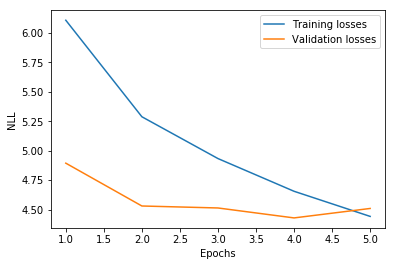

In [23]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [24]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | able to make the way for the first time in
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> In the September 2008 issue of
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single from the US , and was certified platinum by
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | <unk> , <unk> , <unk> , <unk> , <unk> ,
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | to make the song a score of 3 @.@ 5
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | President William Nixon to return to the Royal Navy to
Input | Output #6: <unk> , $ 9